In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
   tf.config.experimental.set_memory_growth(gpus[0], True)

#from tensorflow.layers import concatenate, Input, ZeroPadding2D, Convolution2D, Dense, Dropout, Activation, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from skimage.io import imread, imshow
#from skimage.transform import resize
from pathlib import Path
# from joblib import Parallel, delayed
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

CHECKPOINT_PATH = Path() / 'checkpoints'
LOG_DIR = Path() / 'logs'

DATA_PATH = Path() / 'dataset'
TRAIN_PATH = DATA_PATH / 'train'
TEST_PATH = DATA_PATH / 'test'

#input_size = (530, 730, 3)
#input_size = (512, 512, 3)
input_size = (256, 256, 3)
#input_size = (528, 720, 3)
n_classes = 37
nproc = 4

In [37]:
dropout_rate = 0.5
initializer = 'he_normal'

# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)
drop_1 = Dropout(dropout_rate)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(drop_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)
drop_2 = Dropout(dropout_rate)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(drop_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)
drop_3 = Dropout(dropout_rate)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(drop_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
drop_4 = Dropout(dropout_rate)(conv_enc_4)

# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(drop_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
drop_5 = Dropout(dropout_rate)(conv)

# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(drop_5))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)
drop_6 = Dropout(dropout_rate)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(drop_6))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)
drop_7 = Dropout(dropout_rate)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(drop_7))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)
drop_8 = Dropout(dropout_rate)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(drop_8))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
drop_9 = Dropout(dropout_rate)(conv_dec_4)

# -- Dencoder -- #

output = Conv2D(n_classes, 1, activation = 'softmax')(drop_9)

optm = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')

model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer=optm, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

#tf.keras.utils.plot_model(
#    model, to_file='model.png', show_shapes=True, show_layer_names=True,
#    rankdir='TB', expand_nested=False, dpi=300
#)

In [38]:
def parse_train_image(img_path):
#    print("img_path - {}".format(img_path))
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "rgb", "seg")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
                            
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': image, 'segmentation_mask': mask}

def parse_val_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "rgb", "seg")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image': image, 'segmentation_mask': mask}

In [39]:
all_images = str((TRAIN_PATH / 'rgb').resolve()) + "/*.jpg"
all_tests = str((TEST_PATH / 'rgb').resolve()) + "/*.jpg"

train_dataset = tf.data.Dataset.list_files(all_images, seed=0)
train_dataset = train_dataset.map(parse_train_image)#(parse_image(img_path, 1) for img_path in all_images)

# all_tests = list([str(img.resolve()) for img in (TEST_PATH / 'rgb').iterdir()])
val_dataset = tf.data.Dataset.list_files(all_tests, seed=0)
val_dataset = val_dataset.map(parse_val_image)#(parse_image(img_path, 0) for img_path in all_tests)

In [40]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor):
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask


@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (input_size[0], input_size[1]))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (input_size[0], input_size[1]))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (input_size[0], input_size[1]))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (input_size[0], input_size[1]))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [41]:
BATCH_SIZE = 4
#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000
EPOCHS = 10

STEPS_PER_EPOCH = len(list((TRAIN_PATH / 'rgb').iterdir())) // BATCH_SIZE
VALIDATION_STEPS = len(list((TEST_PATH / 'rgb').iterdir())) // BATCH_SIZE

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=0)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 528, 720, 3), (None, 528, 720, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 528, 720, 3), (None, 528, 720, 1)), types: (tf.float32, tf.float32)>


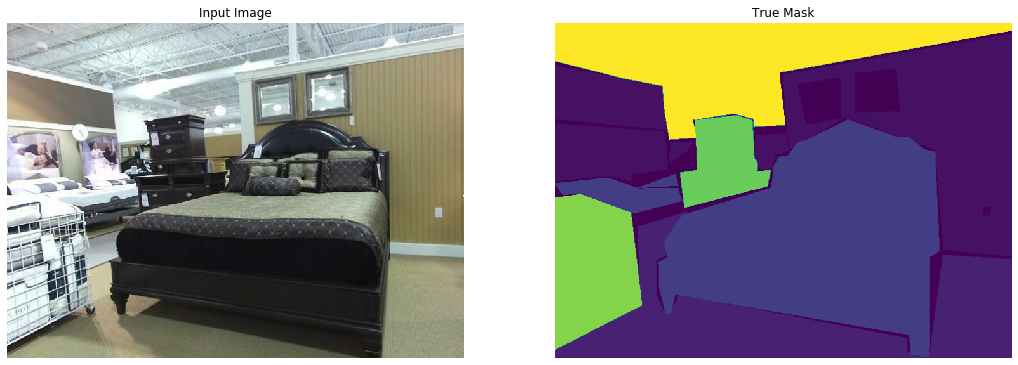

In [29]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [42]:
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

Train for 2067 steps, validate for 516 steps
Epoch 1/10
   1/2067 [..............................] - ETA: 23:04:44

ResourceExhaustedError:  OOM when allocating tensor with shape[4,264,360,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_1/dropout_1/dropout/random_uniform/RandomUniform (defined at <ipython-input-42-bb460d07a172>:17) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_8087]

Function call stack:
distributed_function


In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [ ]:
for im_file in (TRAIN_PATH / 'img').iterdir():
    img = Image.open(str(im_file))
    display.display(img)
    print(img.size)
    break

In [ ]:

def read_image(img_file):
    img = imread(img_file)
    img = resize(img, (530, 730), anti_aliasing=True)
    return img

In [ ]:
x_train = []
x_train.extend(Parallel(n_jobs=nproc)(delayed(read_image)(im_file) for im_file in (TRAIN_PATH / 'img').iterdir()))
#plt.imshow(x_train[0])
imshow(x_train[0])

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
y_train = []
y_train.extend(Parallel(n_jobs=nproc)(delayed(read_image)(str(im_file) for im_file in (TRAIN_PATH / 'seg').iterdir()))
#cv2.imshow(y_train[19])
imshow(y_train[19])

In [ ]:
imshow(x_train[0])

In [ ]:
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir = LOG_DIR),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=10,
                    callbacks=callbacks, use_multiprocessing=False)

In [ ]:
input_size = (530, 730, 3)
encoder = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet',input_shape=input_size, classes=37)

tf.keras.utils.plot_model(
    encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=300
)